<a href="https://colab.research.google.com/github/taniasahu/Automatic-Modulation-Classification-/blob/main/CLDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scipy -q
!pip install tensorflow -q
!pip install numpy -q
!pip install matplotlib -q

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to file location in Google Drive
file_path = '/content/drive/My Drive/AMC_dataset.mat'

Mounted at /content/drive


In [4]:
import numpy as np
import scipy.io as sio
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, AveragePooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Load dataset
data = sio.loadmat(file_path)
X = data['data']  # Shape: (55000, 1024, 2) for I/Q data
y = data['labels'].flatten() - 1  # Convert to 0-based indexing (0-10 for 11 classes)
split = data['split'].flatten()

# Split dataset based on the split array (70/15/15)
X_train = X[split == 0]
y_train = y[split == 0]
X_val = X[split == 1]
y_val = y[split == 1]
X_test = X[split == 2]
y_test = y[split == 2]

# Small data augmentation (Gaussian Noise)
noise = np.random.normal(0, 0.01, X_train.shape)
X_train = X_train + noise

# Define the CLDNN model
input_layer = Input(shape=(1024, 2))  # 1024-sample frames with I/Q channels

# Convolutional blocks (6x [bn, relu, conv, bn, relu, conv, avgpool])
conv_out = input_layer
for _ in range(6):
    conv1 = Conv1D(64, kernel_size=3, padding='same')(conv_out if _ == 0 else conv2)
    bn1 = BatchNormalization()(conv1)
    relu1 = ReLU()(bn1)
    conv2 = Conv1D(64, kernel_size=3, padding='same')(relu1)
    bn2 = BatchNormalization()(conv2)
    relu2 = ReLU()(bn2)
    conv_out = AveragePooling1D(pool_size=2)(relu2)

# LSTM layer for temporal dependencies
lstm_out = LSTM(256, return_sequences=False)(conv_out)

# Fully connected layers with L2 regularization
flatten = Flatten()(lstm_out)
dense1 = Dense(512, activation='relu', kernel_regularizer=l2(0.03))(flatten)  # L2 at 0.03
bn_dense = BatchNormalization()(dense1)  # Batch normalization
dropout = Dropout(0.6)(bn_dense)  # dropout at 0.6
output = Dense(11, activation='softmax', kernel_regularizer=l2(0.03))(dropout)

# Create model
model = Model(inputs=input_layer, outputs=output)

# Compile model with gradient clipping
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Adam + gradient clipping
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', # Loss function : categorical crossentropy
              metrics=['accuracy'])

# Model summary
model.summary()

# Callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=128, verbose=1,  #  batch size at 128
                    callbacks=[reduce_lr, early_stop])

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

# Save model
model.save('cldnn_model.keras')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1024, 64)       │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1024, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1024, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1024, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1024, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1024, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1024, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1024, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 1024, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1024, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 1024, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 1024, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 606,091 (2.31 MB)

 Trainable params: 604,171 (2.30 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 73s 187ms/step - accuracy: 0.3016 - loss: 11.5870 - val_accuracy: 0.1308 - val_loss: 9.1743 - learning_rate: 1.0000e-04
Epoch 2/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 78s 193ms/step - accuracy: 0.6616 - loss: 6.5547 - val_accuracy: 0.7077 - val_loss: 4.4123 - learning_rate: 1.0000e-04
Epoch 3/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 61s 196ms/step - accuracy: 0.7744 - loss: 3.8137 - val_accuracy: 0.8023 - val_loss: 2.6244 - learning_rate: 1.0000e-04
Epoch 4/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 82s 197ms/step - accuracy: 0.8000 - loss: 2.3408 - val_accuracy: 0.8290 - val_loss: 1.6444 - learning_rate: 1.0000e-04
Epoch 5/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 82s 196ms/step - accuracy: 0.8327 - loss: 1.5033 - val_accuracy: 0.7719 - val_loss: 1.3372 - learning_rate: 1.0000e-04
Epoch 6/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 80s 190ms/step - accuracy: 0.8372 - loss: 1.0484 - val_accuracy: 0.8494 - val_loss: 0.8265 - learning_rate: 1.0000e-04
Epoch 7/100
310/310 ━━━━━━━━━━━━━━━━━━━

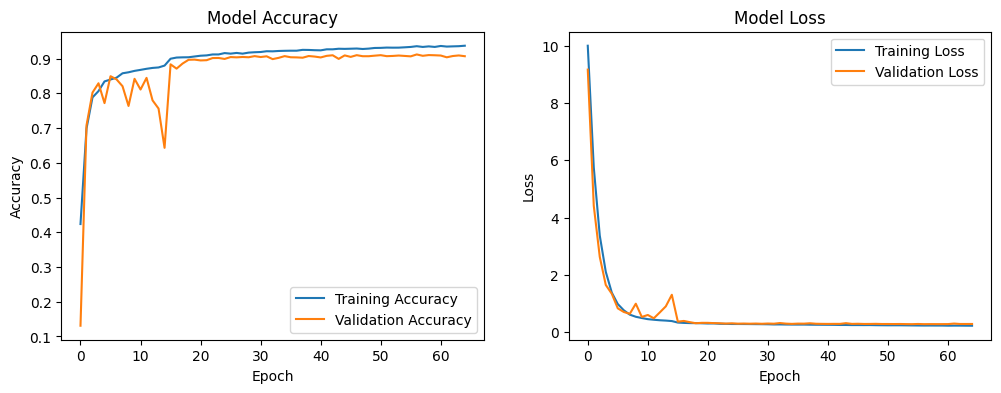

In [5]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Load dataset
sio.loadmat(file_path)
X = data['data']
y = data['labels'].flatten() - 1  # Convert to 0-based indexing
split = data['split'].flatten()

# Get test set
X_test = X[split == 2]
y_test = y[split == 2]

# Load your trained model
model = load_model('cldnn_model.keras')

# Model Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = [ 'BPSK', 'QPSK', '8PSK', '16QAM', '64QAM','PAM4', 'GFSK', 'CPFSK', 'B-FM', 'DSB-AM', 'SSB-AM']

Test Accuracy: 90.36%
Test Loss: 0.2888
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


In [8]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

        BPSK       0.90      0.85      0.87       773
        QPSK       0.66      0.71      0.68       761
        8PSK       0.72      0.75      0.74       751
       16QAM       0.90      0.80      0.85       724
       64QAM       0.91      0.95      0.93       794
        PAM4       0.98      0.98      0.98       737
        GFSK       0.98      0.98      0.98       741
       CPFSK       1.00      1.00      1.00       733
        B-FM       1.00      1.00      1.00       747
      DSB-AM       1.00      1.00      1.00       344
      SSB-AM       1.00      0.99      1.00       553

    accuracy                           0.90      7658
   macro avg       0.91      0.91      0.91      7658
weighted avg       0.91      0.90      0.90      7658



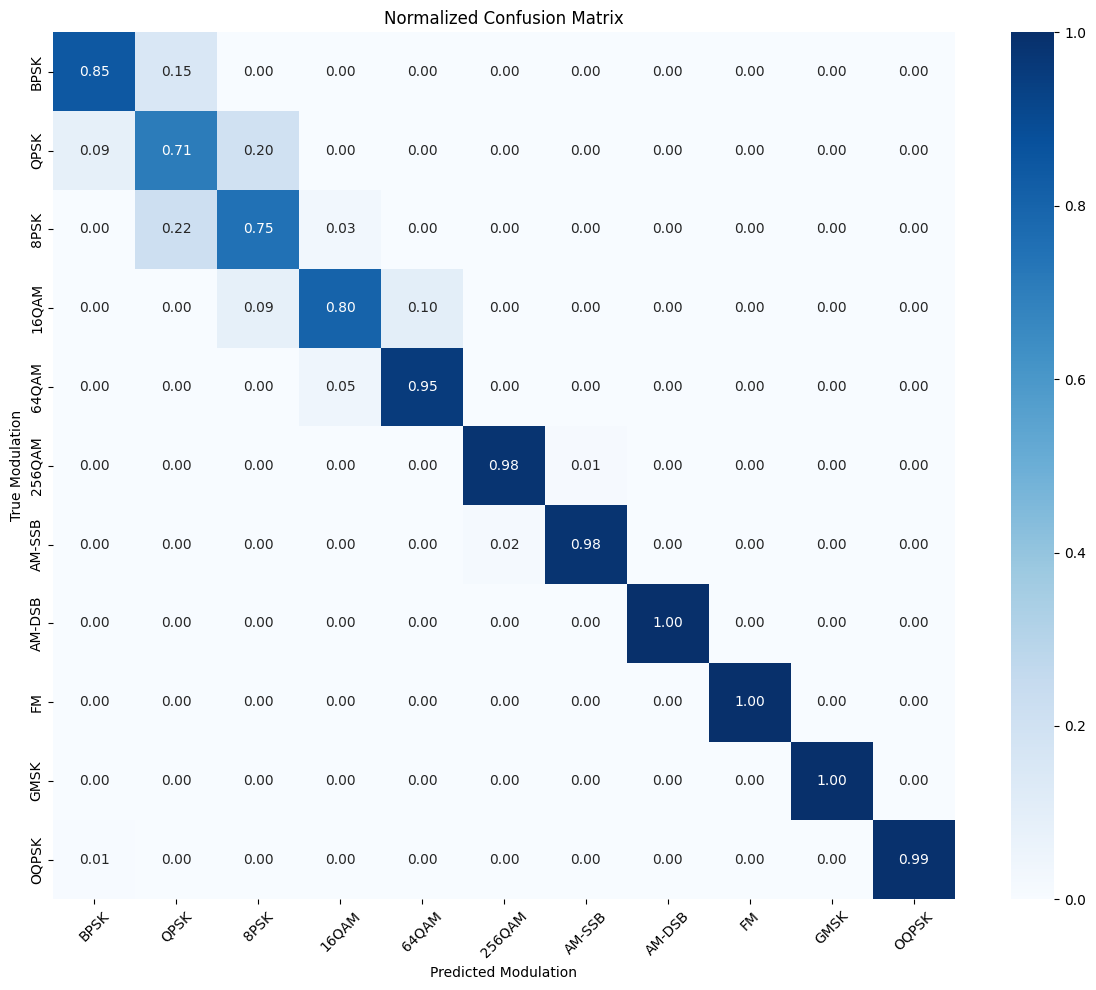

In [15]:
# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)

# Normalize matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Modulation')
plt.ylabel('True Modulation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

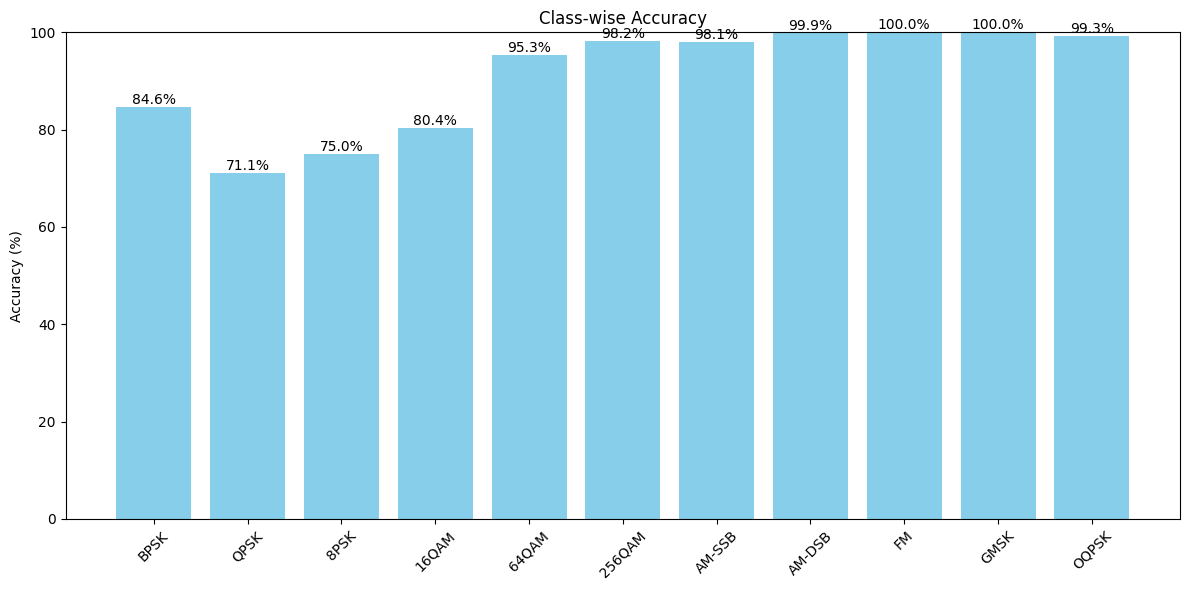

In [14]:
# Class-wise Accuracy
class_accuracy = 100 * cm_norm.diagonal()
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_accuracy, color='skyblue')
plt.title('Class-wise Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)

# Add accuracy values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('class_accuracy.png', dpi=300)
plt.show()

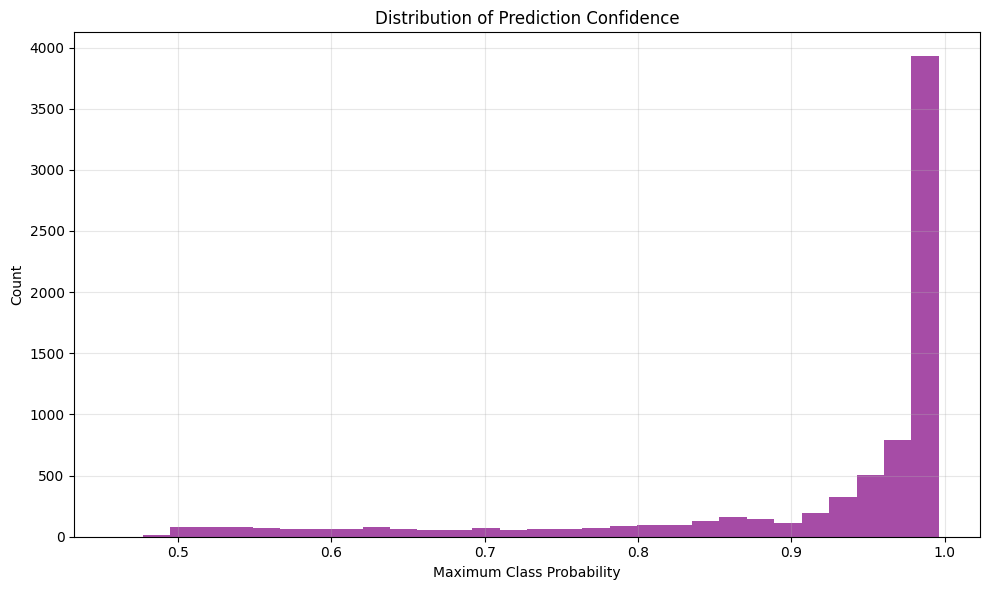

In [13]:
# Prediction Confidence Analysis
plt.figure(figsize=(10, 6))
max_probs = np.max(y_pred, axis=1)
plt.hist(max_probs, bins=30, alpha=0.7, color='purple')
plt.title('Distribution of Prediction Confidence')
plt.xlabel('Maximum Class Probability')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=300)
plt.show()